In [60]:
import csv
import string
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing.image import ImageDataGenerator, array_to_img
from tensorflow.keras.utils import load_img, img_to_array
from tensorflow.keras.applications.resnet50 import preprocess_input, decode_predictions
from tensorflow.keras.preprocessing import image

In [3]:
# Data from https://www.kaggle.com/datasets/datamunge/sign-language-mnist
testing_file_path = './sign_mnist_test.csv'
training_file_path = './sign_mnist_train.csv'

In [5]:
def parse_data(filename):
    with open(filename) as file:
        csv_reader = csv.reader(file, delimiter=',')
        first_line = True
        temp_images, temp_labels = [], []
        for row in csv_reader:
            if first_line:
                first_line = False
            else:
                temp_labels.append(row[0])
                image_data = row[1:]
                img_as_array = np.array_split(image_data, 28)
                temp_images.append(img_as_array)
        images = np.array(temp_images).astype('float')
        labels = np.array(temp_labels).astype('float')
        return images, labels

In [6]:
train_images, train_labels = parse_data(training_file_path)
valid_images, valid_labels = parse_data(testing_file_path)

In [7]:
print(f"Training images has shape: {train_images.shape} and dtype: {train_images.dtype}")
print(f"Training labels has shape: {train_labels.shape} and dtype: {train_labels.dtype}")
print(f"Validation images has shape: {valid_images.shape} and dtype: {valid_images.dtype}")
print(f"Validation labels has shape: {valid_labels.shape} and dtype: {valid_labels.dtype}")

Training images has shape: (27455, 28, 28) and dtype: float64
Training labels has shape: (27455,) and dtype: float64
Validation images has shape: (7172, 28, 28) and dtype: float64
Validation labels has shape: (7172,) and dtype: float64


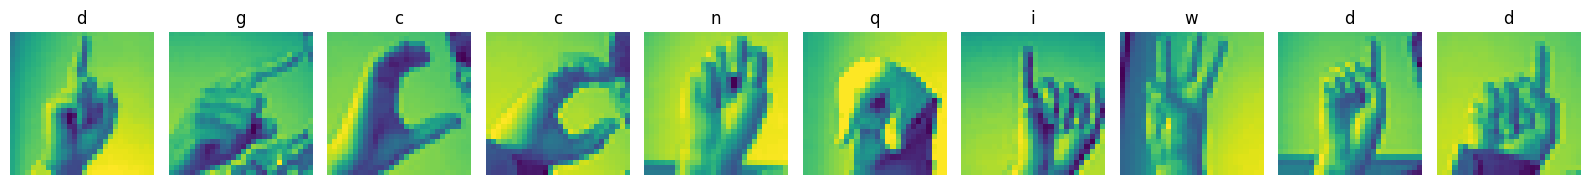

In [29]:
def plot_categories(training_images, training_labels):
  fig, axes = plt.subplots(1, 10, figsize=(16, 15))
  axes = axes.flatten()
  letters = list(string.ascii_lowercase)

  for k in range(10):
    img = training_images[k]
    img = np.expand_dims(img, axis=-1)
    img = array_to_img(img)
    ax = axes[k]
    ax.imshow(img, cmap="Greys_r")
    ax.set_title(f"{letters[int(training_labels[k])]}")
    ax.set_axis_off()

  plt.tight_layout()
  plt.show()

plot_categories(train_images, train_labels)

In [9]:
def train_val_generators(training_images, training_labels, validation_images, validation_labels):
    training_images = np.expand_dims(training_images, axis = 3)
    validation_images = np.expand_dims(validation_images, axis = 3)

    train_datagen = ImageDataGenerator(rescale = 1./255, rotation_range = 40, width_shift_range = 0.2, height_shift_range = 0.2, shear_range = 0.2, zoom_range = 0.2, horizontal_flip = True, fill_mode = 'nearest')
    train_generator = train_datagen.flow(x = training_images, y = training_labels, batch_size = 32)

    validation_datagen = ImageDataGenerator(rescale = 1./255)
    validation_generator = validation_datagen.flow(x = validation_images, y = validation_labels, batch_size = 32) 

    return train_generator, validation_generator

In [10]:
train_generator, validation_generator = train_val_generators(train_images, train_labels, valid_images, valid_labels)

print(f"Images of training generator have shape: {train_generator.x.shape}")
print(f"Labels of training generator have shape: {train_generator.y.shape}")
print(f"Images of validation generator have shape: {validation_generator.x.shape}")
print(f"Labels of validation generator have shape: {validation_generator.y.shape}")

Images of training generator have shape: (27455, 28, 28, 1)
Labels of training generator have shape: (27455,)
Images of validation generator have shape: (7172, 28, 28, 1)
Labels of validation generator have shape: (7172,)


In [89]:
def create_model():
  model = tf.keras.models.Sequential([
    tf.keras.layers.Conv2D(128, (5, 5), strides = 1, padding = 'same', activation='relu', input_shape=(28, 28, 1)),
    tf.keras.layers.MaxPooling2D((2, 2), strides = 2, padding = 'same'),
    tf.keras.layers.Conv2D(64, (3, 3), strides = 1, padding = 'same', activation='relu'),
    tf.keras.layers.MaxPooling2D((2, 2), 2, padding = 'same'),
    tf.keras.layers.Conv2D(32, (2, 2), strides = 1, padding = 'same', activation = 'relu'),
    tf.keras.layers.MaxPooling2D((2, 2), 2, padding = 'same'),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(512, activation='relu'),
    tf.keras.layers.Dropout(0.25),
    tf.keras.layers.Dense(26, activation='softmax')])

  model.compile(optimizer = 'adam', loss = 'sparse_categorical_crossentropy', metrics=['accuracy'])
  
  return model

model = create_model()
model.summary()

Model: "sequential_20"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_49 (Conv2D)          (None, 28, 28, 128)       3328      
                                                                 
 max_pooling2d_49 (MaxPoolin  (None, 14, 14, 128)      0         
 g2D)                                                            
                                                                 
 conv2d_50 (Conv2D)          (None, 14, 14, 64)        73792     
                                                                 
 max_pooling2d_50 (MaxPoolin  (None, 7, 7, 64)         0         
 g2D)                                                            
                                                                 
 conv2d_51 (Conv2D)          (None, 7, 7, 32)          8224      
                                                                 
 max_pooling2d_51 (MaxPoolin  (None, 4, 4, 32)       

In [94]:
history = model.fit(train_generator, epochs = 35, validation_data = validation_generator, batch_size = 200)

Epoch 1/35
858/858 [==============================] - 87s 101ms/step - loss: 1.3867 - accuracy: 0.5395 - val_loss: 0.8753 - val_accuracy: 0.6965
Epoch 2/35
858/858 [==============================] - 105s 123ms/step - loss: 1.1037 - accuracy: 0.6278 - val_loss: 0.6376 - val_accuracy: 0.7613
Epoch 3/35
858/858 [==============================] - 86s 100ms/step - loss: 0.9057 - accuracy: 0.6943 - val_loss: 0.4046 - val_accuracy: 0.8642
Epoch 4/35
858/858 [==============================] - 82s 95ms/step - loss: 0.7994 - accuracy: 0.7297 - val_loss: 0.3949 - val_accuracy: 0.8696
Epoch 5/35
858/858 [==============================] - 84s 97ms/step - loss: 0.7199 - accuracy: 0.7564 - val_loss: 0.3544 - val_accuracy: 0.8822
Epoch 6/35
858/858 [==============================] - 79s 93ms/step - loss: 0.6394 - accuracy: 0.7833 - val_loss: 0.2598 - val_accuracy: 0.9046
Epoch 7/35
858/858 [==============================] - 86s 100ms/step - loss: 0.5829 - accuracy: 0.8031 - val_loss: 0.2217 - val_accu

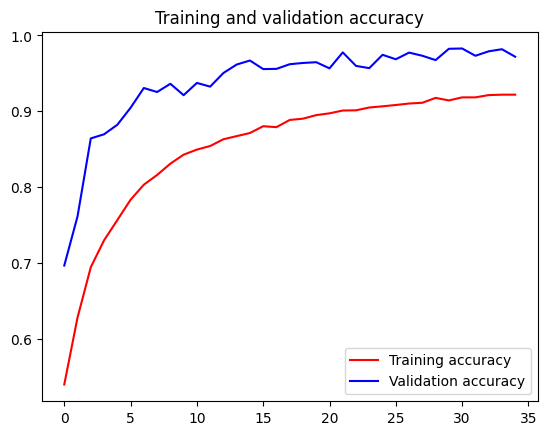

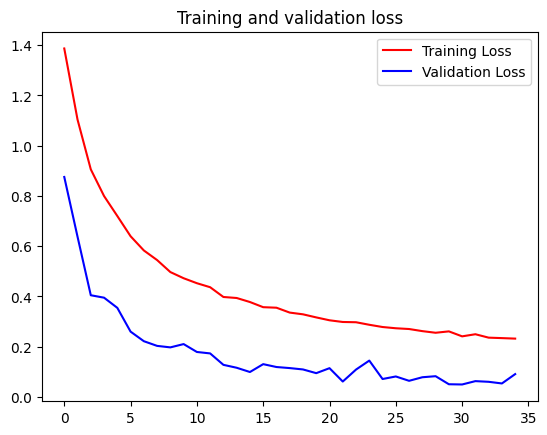

In [95]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(acc))

plt.plot(epochs, acc, 'r', label='Training accuracy')
plt.plot(epochs, val_acc, 'b', label='Validation accuracy')
plt.title('Training and validation accuracy')
plt.legend()
plt.figure()

plt.plot(epochs, loss, 'r', label='Training Loss')
plt.plot(epochs, val_loss, 'b', label='Validation Loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

In [96]:
(ls,acc) = model.evaluate(validation_generator)

225/225 [==============================] - 4s 18ms/step - loss: 0.0907 - accuracy: 0.9720


In [97]:
print('Accuracy of Model = {}%'.format(acc * 100))

Accuracy of Model = 97.19743728637695%


1/1 [==============================] - 0s 102ms/step
b


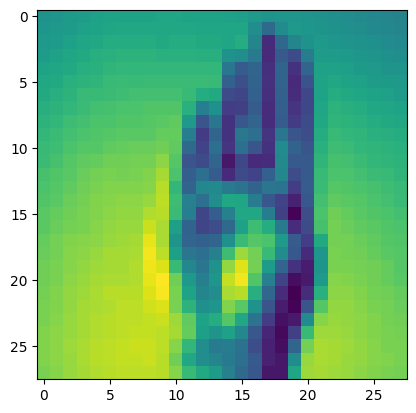

In [98]:
image_index = 500
letters = list(string.ascii_lowercase)
plt.imshow(valid_images[image_index].reshape(28, 28))
pred = model.predict(valid_images[image_index].reshape(1, 28, 28, 1))
print(letters[int(valid_labels[image_index])])